In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import time
import glob
from collections import Counter
style.use('ggplot')
import quandl
import os

In [2]:
# define a function to summarize single CSV file
def summary_from_csv_file(filename):
    
    # read in csv file
    df = pd.read_csv(filename, index_col = 0)
    
    # generate summary data frame
    summary_df = pd.DataFrame({
        "Account": [df['Account Name'][0]],
        "Created": df['Account Created Date'][0],
        "Followers Count": df['Followers Count'][0],
        "Tweets Count": len(df),
        "Start Date": df['Tweet Date'][len(df)-1],
        "End Date": df['Tweet Date'][0],
        "Account Location": df['Account Location'][0]
    }, columns = ["Account", "Created", "Tweets Count", "Start Date", "End Date",
                         "Followers Count", "Account Location"])
    
    # return data frame
    return summary_df

In [3]:
# define a function to summarize multiple CSV files in a same folder
def generate_summary_table(folder):
    
    # define file path
    csvpath = os.path.join(folder, '*.csv')
    
    # generate CSV file list
    file_list = glob.glob(csvpath)
    
    # generate an empty data frame
    df = pd.DataFrame({
            "Account": [],
            "Created": [],
            "Followers Count": [],
            "Tweets Count": [],
            "Start Date": [],
            "End Date": [],
            "Account Location": []
        }, columns = ["Account", "Created", "Tweets Count", "Start Date", "End Date",
                             "Followers Count", "Account Location"])
    
    # loop through csv files, extract summary data and put together
    for file in file_list:
        summary = summary_from_csv_file(file)
        df = pd.concat([df, summary])
    
    # drop Twitter accounts with less than 100 tweets
    df = df.loc[df['Tweets Count']>100]
    df.reset_index(drop = True, inplace = True)
    
    # return the data frame
    return df

In [4]:
# calculate x tick location and define x tick label
def x_ticks_for_graphs():
    
    # important dats shown on future x axis
    date_list = ["2008-1-1", "2009-1-1", "2010-1-1", "2011-1-1", "2012-1-1", "2013-1-1",
                 "2014-1-1", "2015-1-1", "2016-1-1", "2017-1-1", "2018-1-1"]
    
    # convert from string to datetime object
    converted_list = []
    for date in date_list:
        converted = datetime.strptime(date, "%Y-%m-%d")
        converted_list.append(converted)
    
    # calculate xticks location
    today = datetime.strptime("2018-3-18", "%Y-%m-%d")
    xticks_location = []
    for date in converted_list:
        diff = date - today
        xticks_location.append(diff.days)
    
    # define x tick label
    xlabel = ["2008", "2009", "2010", "2011", "2012", "2013",
             "2014", "2015", "2016", "2017", "2018"]
    
    return xticks_location, xlabel

In [5]:
def bar_graph_for_tweets_time_coverage(dataframe, xticks_location, xlabel):
    
    # generate two empty columns for days ago calculation
    dataframe["Start to now"] = ""
    dataframe["End to now"] = ""
    
    # define now
    now = datetime.date(datetime.strptime('2018-3-18', "%Y-%m-%d"))
    
    # fill in the two new columns after calculation
    for index, row in dataframe.iterrows():
        start = datetime.strptime(row['Start Date'], "%a %b %d %H:%M:%S %z %Y")
        start = datetime.date(start)
        diff_start = (start - now).days
        end = datetime.strptime(row['End Date'], "%a %b %d %H:%M:%S %z %Y")
        end = datetime.date(end)
        diff_end = (end - now).days
        dataframe.set_value(index, "Start to now", diff_start)
        dataframe.set_value(index, "End to now", diff_end)
    
    # generate graph
    # define x, y & xerror
    y = range(len(dataframe))
    x = np.array(dataframe["End to now"])
    for i in range(len(dataframe)):
        x[i] = int(x[i])
    xerr = x- np.array(dataframe["Start to now"])
    for i in range(len(dataframe)):
        xerr[i] = int(xerr[i])
    
    # generate bar graph, save fig and show fig
    fig, ax = plt.subplots(figsize=(14,10))
    ax.errorbar(x, y, xerr=xerr, 
                elinewidth=3, capsize=5, color="g", linewidth=0, xuplims = True)
    plt.yticks(y, dataframe["Account"])
    plt.xticks(xticks_location, xlabel)
    ax.yaxis.tick_right()
    plt.xlim(-3800, 20)
    plt.ylim(-0.5, 37.5)
    plt.title("Time Frame of Downloaded Tweets")
    plt.savefig("TweetsTimeFrame.png")
    plt.show()
    
    # return xerr (days the tweets covered) for future plot
    return xerr

In [6]:
def bubble_chart_of_Twitter_accounts(dataframe, covered_days, xticks_location, xlabel):
    
    # generate empty list to store create date (x axis for chart)
    Create_date_list = []
    for i in range(len(dataframe)):
        converted = datetime.strptime(dataframe["Created"][i], "%a %b %d %H:%M:%S %z %Y")
        Create_date_list.append(converted)
    
    # calculate Tweet frequency per week of each account, then define size for chart
    dataframe["Tweet Freq"] = dataframe["Tweets Count"]/covered_days*7
    size = [int(dataframe["Tweet Freq"][i])*7 for i in range(len(dataframe))]
    
    # generate bubble chart, save fig, show fig
    plt.figure(figsize=(12,8))
    plt.scatter(Create_date_list, dataframe["Followers Count"], c='g', s=size, edgecolors="r")
    plt.yscale('log')
    plt.title("Twitter Account Information")
    plt.ylabel("Follower Count")
    plt.xlabel("Account Creation Date")
    plt.legend(["Tweets \n Frequency"], loc='best', markerscale=0.5, fancybox = True, edgecolor="black")
    plt.savefig("TwitterAccount.png")
    plt.show()
    return Create_date_list

In [7]:
def Twitter_acc_accum_vs_bitcoin(Create_date_list, xticks_location, xlabel):
    
    # calculation accounts accumulation
    Create_date_list.sort()
    acc_accum = []
    count = 1
    for date in Create_date_list:
        acc_accum.append(count)
        count = count + 1
    
    # calculate 'days ago' for x axis
    today = datetime.date(datetime.strptime("2018-3-18", "%Y-%m-%d"))
    x_axis = []
    for date in Create_date_list:
        date = datetime.date(date)
        diff = date - today
        x_axis.append(diff.days)
    
    # read in bitcoin price info, calculate x axis for bitcoin price
    coin = pd.read_csv("bitcoinPrice.csv", index_col = 0)
    Coin_x_axis = []
    for i in range(len(coin)):
        date = datetime.date(datetime.strptime(coin['Date'][i], "%Y-%m-%d"))
        diff = date - today
        Coin_x_axis.append(diff.days)
    
    # generate plots for both, save fig and show fig
    fig, ax1 = plt.subplots(figsize = (10, 8))
    color = 'tab:red'
    ax1.set_ylabel('USD', color=color)
    ax1.plot(Coin_x_axis, coin['Close'], label = "Bitcoin Price")
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accum Account Number', color=color)
    ax2.plot(x_axis, acc_accum, marker = "o", color = "b", markersize = 3.0,
                label = "Twitter Accounts")
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
    plt.xticks(xticks_location, xlabel)
    plt.xlim(-3000, 0)
    plt.savefig("AccountvsPrice.png")
    plt.show()


In [8]:
# define a function put all together
def Evaluate_N_Visulize_CSVs(folder):
    df = generate_summary_table(folder)
    xticks_location, xlabel = x_ticks_for_graphs()
    covered_days = bar_graph_for_tweets_time_coverage(df, xticks_location, xlabel)
    Create_date_list = bubble_chart_of_Twitter_accounts(df, covered_days, xticks_location, xlabel)
    Twitter_acc_accum_vs_bitcoin(Create_date_list, xticks_location, xlabel)

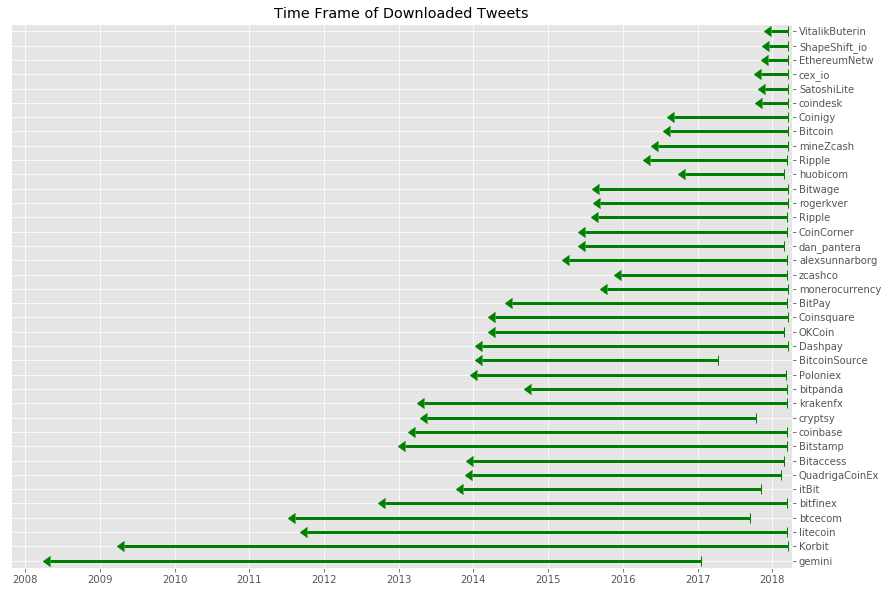

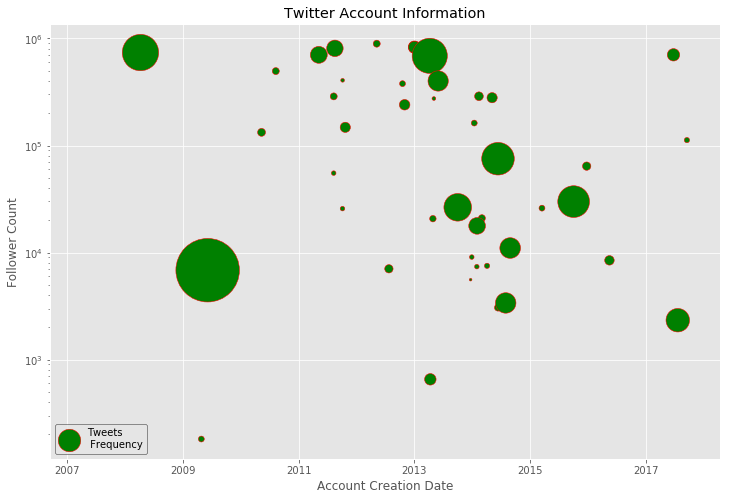

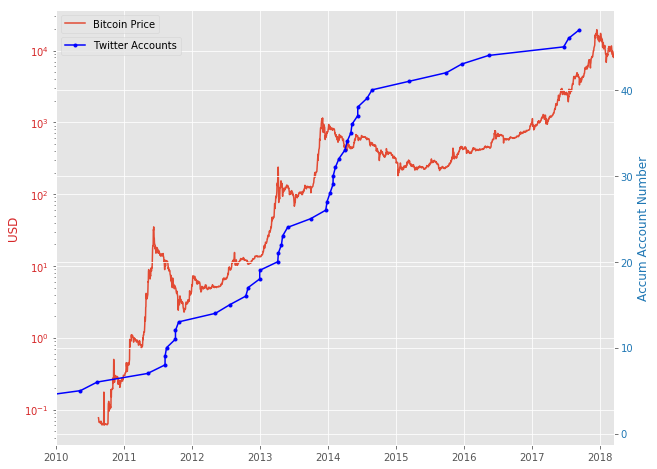

In [9]:
Evaluate_N_Visulize_CSVs('CSVfiles')